In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
from functools import partial

In [3]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_spa as spa
import seaborn as sns

In [4]:
%aimport cue
from cue.analysis.analysis import bootstrap_ci
from cue.analysis.context import ContextTestEnv, plot_ctx_net_analysis
from cue.model.legacy.context import AlternatingMemoryBuffers, BoundedIntegrator, Context5

from cue.utils.plotting import *

In [5]:
style()

In [6]:
def eval_net(model, env):
    with nengo.Simulator(model) as sim:
        sim.run(env.n)
        
    return sim.trange(), sim.data[model.p_recalled_ctx], sim.data[model.p_ctx]

def figpath(name):
    return '../../../phd-thesis/figures/context-analysis/' + name

In [7]:
def ci_l(x, func):
    return bootstrap_ci(x, func)[0]

def ci_u(x, func):
    return bootstrap_ci(x, func)[1]

statistic = lambda func: (func, partial(ci_l, func=func), partial(ci_u, func=func))

# Bounded integrator

In [8]:
def BoundedIntegratorTest(env):
    with spa.Network(seed=2) as model:
        model.config[spa.State].represent_identity = False
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = BoundedIntegrator(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(context_net.current.output, initialization_node)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

In [9]:
env1 = ContextTestEnv(1)
t1, _, ctx1 = eval_net(BoundedIntegratorTest(env1), env1)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:06.                                                                                           
Simulating finished in 0:01:05.                                                                                         


In [10]:
env2 = ContextTestEnv(1, beta_stim=0.6)
t2, _, ctx2 = eval_net(BoundedIntegratorTest(env2), env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:06.                                                                                           
Simulating finished in 0:01:02.                                                                                         


In [11]:
def mean_ctx_sim(t, ctx, env):
    dfs = []
    out_normed = ctx / np.linalg.norm(ctx, axis=1, keepdims=True)
    for i in range(1, env.n):
        start = int((i + .7) / env.dt)
        end = int((i + 1.) / env.dt)
        target = np.mean(out_normed[start:end], axis=0)
        dfs.append(pd.DataFrame({'t': t - i, 'y': np.dot(out_normed, target)}))
    return pd.concat(dfs).groupby('t').agg(statistic(np.mean))

In [12]:
df1 = mean_ctx_sim(t1, ctx1, env1)
df2 = mean_ctx_sim(t2, ctx2, env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


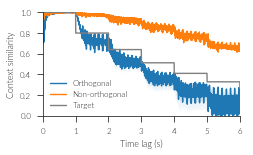

In [13]:
fig = plt.figure(figsize=single_fig_size)

ax = fig.add_subplot(1, 1, 1)

ax.plot(df1.index, df1['y', 'mean'], label="Orthogonal")
ax.fill_between(df1.index, df1['y', 'ci_l'], df1['y', 'ci_u'], alpha=.3)
ax.plot(df2.index, df2['y', 'mean'], label="Non-orthogonal")
ax.fill_between(df2.index, df2['y', 'ci_l'], df2['y', 'ci_u'], alpha=.3)

target = lambda t, x: np.sqrt(1. - x**2)**np.floor(t)
ax.plot(df1.index, target(df1.index, env1.beta), color='gray', label="Target")

ax.set_xlim(0., 6)
ax.set_ylim(0., 1.)
ax.legend(loc='lower left')
ax.set_xlabel("Time lag (s)")
ax.set_ylabel("Context similarity")

sns.despine(fig)
fig.tight_layout()

In [14]:
save_tight_fig(fig, figpath('bounded-integrator.pdf'))

# Alternating update of two memory buffers

In [15]:
def AlternatingMemoryBuffersTest(env):
    with spa.Network(seed=2) as model:
        model.config[spa.State].represent_identity = False
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = AlternatingMemoryBuffers(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        init_phase = nengo.Node(lambda t: t < env.init_phase)
        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(init_phase, context_net.update_done.neurons,
                         transform=-2. * np.ones((context_net.update_done.n_neurons, 1)))
        nengo.Connection(init_phase, context_net.invert.neurons,
                         transform=-2. * np.ones((context_net.invert.n_neurons, 1)))

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
        
    return model

In [16]:
env1 = ContextTestEnv(1)
t1, _, ctx1 = eval_net(AlternatingMemoryBuffersTest(env1), env1)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:02.                                                                                           
Simulating finished in 0:00:37.                                                                                         


In [17]:
env2 = ContextTestEnv(1, beta_stim=0.6)
t2, _, ctx2 = eval_net(AlternatingMemoryBuffersTest(env2), env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:02.                                                                                           
Simulating finished in 0:00:34.                                                                                         


In [18]:
df1 = mean_ctx_sim(t1, ctx1, env1)
df2 = mean_ctx_sim(t2, ctx2, env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


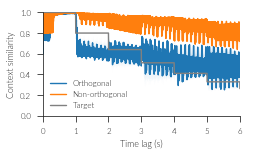

In [19]:
fig = plt.figure(figsize=single_fig_size)

ax = fig.add_subplot(1, 1, 1)

ax.plot(df1.index, df1['y', 'mean'], label="Orthogonal")
ax.fill_between(df1.index, df1['y', 'ci_l'], df1['y', 'ci_u'], alpha=.3)
ax.plot(df2.index, df2['y', 'mean'], label="Non-orthogonal")
ax.fill_between(df2.index, df2['y', 'ci_l'], df2['y', 'ci_u'], alpha=.3)

target = lambda t, x: np.sqrt(1. - x**2)**np.floor(t)
ax.plot(df1.index, target(df1.index, env1.beta), color='gray', label="Target")

ax.set_xlim(0., 6)
ax.set_ylim(0., 1.)
ax.legend(loc='lower left')
ax.set_xlabel("Time lag (s)")
ax.set_ylabel("Context similarity")

sns.despine(fig)
fig.tight_layout()

In [20]:
save_tight_fig(fig, figpath('amb.pdf'))

# Externally controlled alternating memory buffers

In [21]:
class UpdateContext(object):
    def __init__(self, env):
        self.env = env
        
    def __call__(self, t):
        if t < self.env.init_phase or (t > 1. and .0 < (t % 1.) < .7):
            return 1.
        else:
            return 0.

def ExtControlTest(env):
    with nengo.Network(seed=2) as model:
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = Context5(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        nengo.Connection(nengo.Node(UpdateContext(env)), context_net.input_update_context)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(initialization_node, context_net.old.input)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

In [22]:
env1 = ContextTestEnv(1)
t1, _, ctx1 = eval_net(ExtControlTest(env1), env1)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:40.                                                                                         


In [23]:
env2 = ContextTestEnv(1, beta_stim=0.6)
t2, _, ctx2 = eval_net(ExtControlTest(env2), env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:44.                                                                                         


In [24]:
df1 = mean_ctx_sim(t1, ctx1, env1)
df2 = mean_ctx_sim(t2, ctx2, env2)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


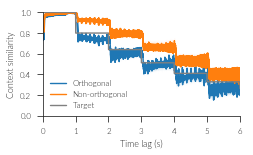

In [25]:
fig = plt.figure(figsize=single_fig_size)

ax = fig.add_subplot(1, 1, 1)

ax.plot(df1.index, df1['y', 'mean'], label="Orthogonal")
ax.fill_between(df1.index, df1['y', 'ci_l'], df1['y', 'ci_u'], alpha=.3)
ax.plot(df2.index, df2['y', 'mean'], label="Non-orthogonal")
ax.fill_between(df2.index, df2['y', 'ci_l'], df2['y', 'ci_u'], alpha=.3)

target = lambda t, x: np.sqrt(1. - x**2)**np.floor(t)
ax.plot(df1.index, target(df1.index, env1.beta), color='gray', label="Target")

ax.set_xlim(0., 6)
ax.set_ylim(0., 1.)
ax.legend(loc='lower left')
ax.set_xlabel("Time lag (s)")
ax.set_ylabel("Context similarity")

sns.despine(fig)
fig.tight_layout()

In [26]:
save_tight_fig(fig, figpath('ext-amb.pdf'))